# Setup


In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm
import statistics

# import plotly as py
# import plotly.plotly as py
# import plotly.tools as plotly_tools
# import plotly.graph_objs as go
# # from matplotlib.finance import quotes_historical_yahoo
# from IPython.display import HTML

In [2]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

In [3]:
# import plotly.express as px
# fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
# fig.write_html('first_figure.html', auto_open=True)
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999')
              # D = dominant = right; N = nondominant = left
yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq


<ipython-input-3-a7ad8f48d14a>:41: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-3-a7ad8f48d14a>:41: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


# Imputed Disturbance delta = (1+MB)u

## linear interp B over all freq & compute delta

In [4]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)] #index 0~40
unwanted_index = {4,  6, 10, 14, 22, 26, 34, 38} #stim_index
nonstimulated_index = [i for i in indexone if i not in unwanted_index] #nonstim index below 1Hz

In [5]:
for p in range(participants_num): # number of participants = 15
    for c in range(num_cond):  # number of conditions  = 7
        DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'] = []
        DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta'] = []
        DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'] = []
        DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_phase'] = []

        for i in range(trialnum[c]//2):
            Inter_abs = np.interp(xf[indexone],stimulated_freq, abs(TF['B']['subject'+str(p)]['condition'+str(c)][i]))
            Inter_phase= np.interp(xf[indexone],stimulated_freq, np.angle(TF['B']['subject'+str(p)]['condition'+str(c)][i]))
            B_interp = [complex(Inter_abs[i],Inter_phase[i]) for i in range(len(xf[indexone]))]
            DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'].append(B_interp)
        for i in range(trialnum[c]):
            B_interp = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'][i//2]
            #delta = (1+MB)*UX
            UX = np.zeros((len(indexone)))
            UX[nonstimulated_index] = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][i]
            delta = (1 + M_h[indexone] * B_interp)*UX
            delta_mag = np.abs(delta)
            delta_phase = np.angle(delta)
            DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta'].append(delta)
            DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'].append(delta_mag)
            DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_phase'].append(delta_phase)


<ipython-input-5-1c7a1092a616>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  UX[nonstimulated_index] = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][i]


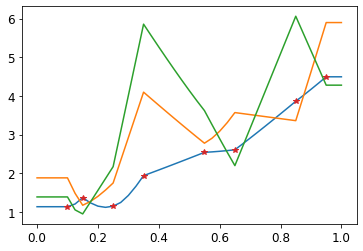

In [6]:
#plot B
p = 0
c = 0
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'][0]) )
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'][1]) )
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'][2]) )

plt.plot(stimulated_freq, np.abs(np.asarray( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Binterp'][0] )[stimulated_index]),'*')

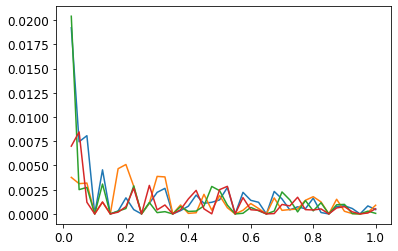

In [7]:
#plot delta of one trial
p = 0
c = 0
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'][0]) )
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'][1]) )
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'][2]) )
plt.plot(xf[indexone],np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'][3]) )

## Average delta of each participants

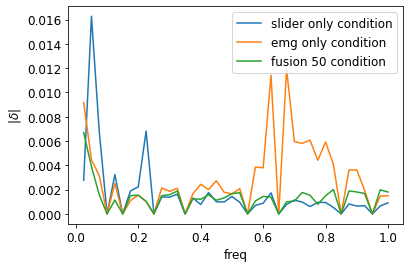

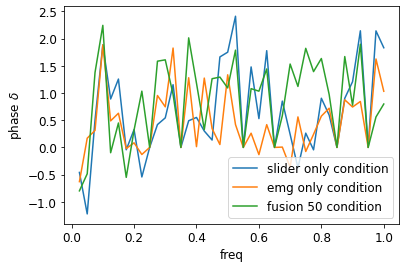

In [8]:
#plot average delta of slider only & emg only condition
p = 10
plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(0)]['delta_mag'], axis = 0),label = 'slider only condition')
plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(1)]['delta_mag'], axis = 0),label = 'emg only condition')
plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(2)]['delta_mag'], axis = 0),label = 'fusion 50 condition')
plt.legend()
plt.xlabel('freq')
plt.ylabel(r'$|\delta|$')
plt.show()

plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(0)]['delta_phase'], axis = 0),label = 'slider only condition')
plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(1)]['delta_phase'], axis = 0),label = 'emg only condition')
plt.plot(xf[indexone],np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(2)]['delta_phase'], axis = 0),label = 'fusion 50 condition')
plt.legend()
plt.xlabel('freq')
plt.ylabel(r'phase $\delta$')
plt.show()


In [9]:
# #take average of "delta" of each condition and each participant(across all trials)
avgdelta_mag = {}
for p in range(participants_num):
    avgdelta_mag['subject'+str(p)] = {}
    for c in range(num_cond): 
        avgdelta_mag['subject'+str(p)]['condition'+str(c)] = np.mean(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta_mag'],axis = 0)
    
    #average delta of condition 0 & 5 (slider only)
    avgdelta_mag['subject'+str(p)]['slider'] = np.mean([avgdelta_mag['subject'+str(p)]['condition'+str(0)],avgdelta_mag['subject'+str(p)]['condition'+str(5)]],axis = 0)
    # #average delta of condition 1 & 6 (emg only)
    avgdelta_mag['subject'+str(p)]['emg'] = np.mean([avgdelta_mag['subject'+str(p)]['condition'+str(1)],avgdelta_mag['subject'+str(p)]['condition'+str(6)]],axis = 0)


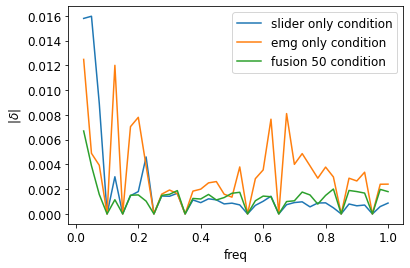

In [10]:
#plot average delta of slider only & emg only condition
p = 10
plt.plot(xf[indexone],avgdelta_mag['subject'+str(p)]['slider'],label = 'slider only condition')
plt.plot(xf[indexone],avgdelta_mag['subject'+str(p)]['emg'],label = 'emg only condition')
plt.plot(xf[indexone],avgdelta_mag['subject'+str(p)]['condition2'],label = 'fusion 50 condition')
plt.legend()
plt.xlabel('freq')
plt.ylabel(r'$|\delta|$')
plt.show()


## IFFT - delta in time domain

Text(0.5, 0, 'freq')

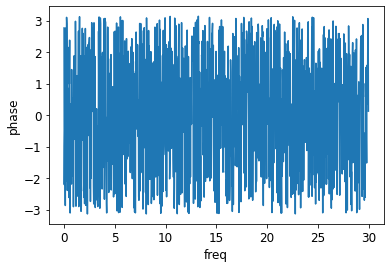

In [11]:
#generate random phases (-pi~pi)
ran_phase = np.random.rand(N)*2*np.pi - np.pi
plt.plot(xf,ran_phase[:N//2])
plt.ylabel('phase')
plt.xlabel('freq')

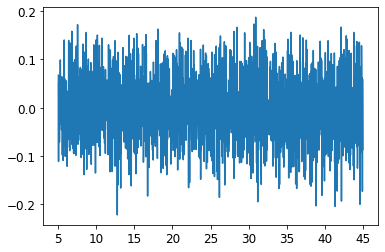

In [12]:
#time domain and PSD
def IFFT(data,N):
  return (fft.ifft(data)*N).real

#polar coordinate to imginary numbers
def P2R(radius, angles):
    return radius * np.exp(1j*angles)

#create new "white noise" delta with average delta mag (1 value) and random phases
avg_mag = avgdelta_mag['subject'+str(p)]['slider']
avg_mag[0] = 0
delta_ = np.asarray([P2R(np.mean(avg_mag), ran_phase[i]) for i in range(N)]) 
delta_time = IFFT(delta_,N)
plt.plot(t,delta_time)

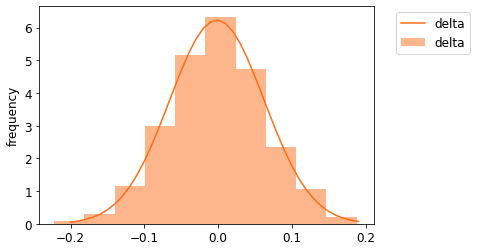

In [13]:
plt.hist(delta_time,alpha=0.5,density=True,label = 'delta',color=colors['d'])
x_axis = np.arange(-0.2, 0.2, 1e-2)
mean_d = statistics.mean(delta_time)
sd_d = statistics.stdev(delta_time)
var_d = statistics.variance(delta_time)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='delta',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [14]:
avgdelta_time = {}
for p in range(participants_num):
    avgdelta_time['subject'+str(p)] = {}

    avg_mag = avgdelta_mag['subject'+str(p)]['slider']
    avg_mag[0] = 0
    delta_ = np.asarray([P2R(np.mean(avg_mag), ran_phase[i]) for i in range(N)]) 
    avgdelta_time['subject'+str(p)]['slider'] = IFFT(delta_,N)

    avg_mag = avgdelta_mag['subject'+str(p)]['emg']
    avg_mag[0] = 0
    delta_ = np.asarray([P2R(np.mean(avg_mag), ran_phase[i]) for i in range(N)]) 
    avgdelta_time['subject'+str(p)]['emg'] = IFFT(delta_,N)

In [15]:
avgdelta = {'avgdelta_mag': avgdelta_mag, #mean of magnitide of delta (freq domain) for each participant
            'avgdelta_time': avgdelta_time} #time domain noise (from slider-only and emg-only) for each participant 

import pickle
delta_file = open("AvgDelta.pkl", "wb")
pickle.dump(avgdelta, delta_file)
delta_file.close()

## PSD of imputed disturbance delta = (1+ MB)u

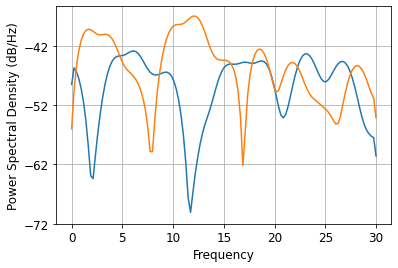

In [148]:
d0 = np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta'][0])
d0[0] = 0
d0_time = IFFT(d0,N) 
d1 = np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['delta'][1])
d1[0] = 0
d1_time = IFFT(d1,N) 
plt.psd(d0_time,Fs = fs)
plt.psd(d1_time,Fs = fs)
plt.show()

C:\Users\amber\anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  warnings.warn('nperseg = {0:d} is greater than input length '


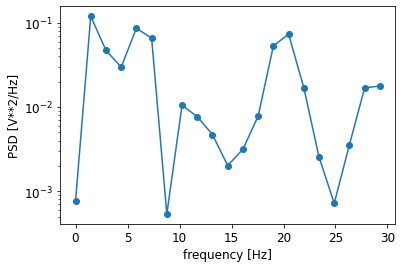

In [178]:
#Welch method for PSD
f, Pxx_den = signal.welch(delta_time, fs=fs)
plt.semilogy(f, Pxx_den,"-o")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# White noise

In [6]:
mean = 0
std = 1 
delta = np.random.normal(mean, std, size=len(t))
e = np.random.normal(mean, std, size=len(t))

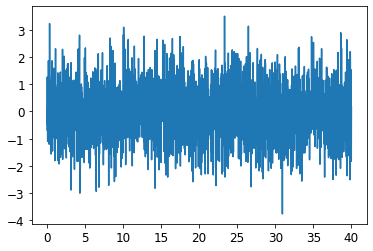

In [7]:
plt.plot(t-5,delta)

(array([  2.,  26., 109., 351., 612., 684., 429., 152.,  29.,   6.]),
 array([-3.83328452, -3.08071156, -2.3281386 , -1.57556564, -0.82299268,
        -0.07041972,  0.68215324,  1.4347262 ,  2.18729916,  2.93987212,
         3.69244508]),
 <BarContainer object of 10 artists>)

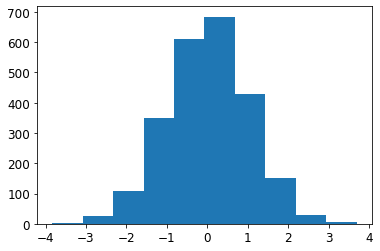

In [21]:
plt.hist(delta)

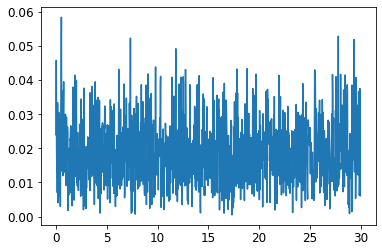

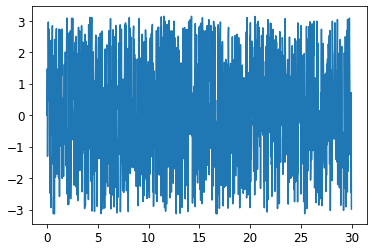

In [20]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

plt.plot(xf,abs(FFT(delta,N))[:N//2])
plt.show()
plt.plot(xf,np.angle(FFT(delta,N))[:N//2])
plt.show()

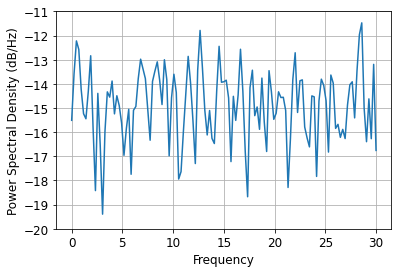

In [15]:
Pxx, f = plt.psd(delta,Fs = fs)

# Empirical d

## power spec of d

In [153]:
d = DATA['TIME']['subject'+str(0)]['condition'+str(0)]['d'][0]

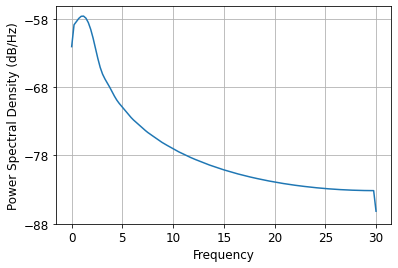

In [237]:
Pxx, f = plt.psd(d,Fs = fs)
# plt.xlim([0,1])

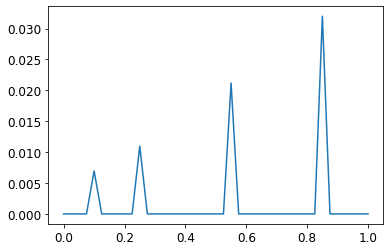

In [240]:
d = DATA['FREQ']['subject'+str(0)]['condition'+str(0)]['D'][0][indexone]
plt.plot(xf[indexone],np.abs(d))

## histogram r,d

In [25]:
i = 9
r = DATA['TIME']['subject0']['condition0']['r'][i]
d = DATA['TIME']['subject0']['condition0']['d'][i]
d = np.concatenate(d)

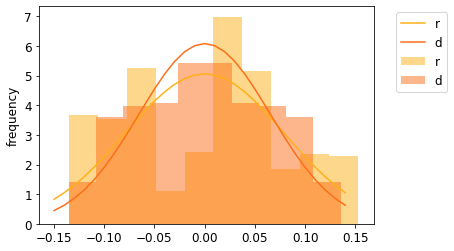

In [26]:
# bins=np.histogram(np.hstack((e_emgonly.flatten(),e_slideronly.flatten(),e_fusion50.flatten())), bins=50)[1] #get the bin edges
plt.hist(r,alpha=0.5,label = 'r',density=True,color=colors['r'])
plt.hist(d,alpha=0.5,density=True,label = 'd',color=colors['d'])

# Calculating mean and standard deviation
x_axis = np.arange(-0.15, 0.15, 1e-2)
mean_r = statistics.mean(r)
sd_r = statistics.stdev(r)
var_r = statistics.variance(r)
plt.plot(x_axis, norm.pdf(x_axis, mean_r, sd_r),label='r',color=colors['r'])

mean_d = statistics.mean(d)
sd_d = statistics.stdev(d)
var_d = statistics.variance(d)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='d',color=colors['d'])

# plt.title('tracking error (r-y)')
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

## delta1 and delta2 from 1-modality 

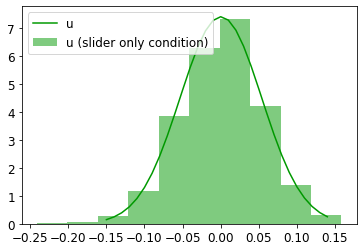

In [32]:

u = []
for i in range(trialnum[0]):
    u.append( DATA['TIME']['subject0']['condition0']['u'][i])
u = np.concatenate(u)

plt.hist(u,alpha=0.5,label = 'u (slider only condition)',density=True,color=colors['u'])

# Calculating mean and standard deviation
x_axis = np.arange(-0.15, 0.15, 1e-2)
mean_u = statistics.mean(u)
sd_u = statistics.stdev(u)
var_u = statistics.variance(u)
plt.plot(x_axis, norm.pdf(x_axis, mean_u, sd_u),label='u',color=colors['u'])
plt.legend()
plt.show()



In [33]:
mean_u

0.0002722082470159158

In [35]:
sd_u

0.05375512426593464

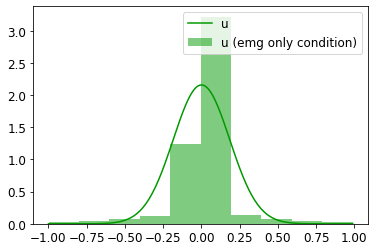

In [241]:
u = []
for i in range(trialnum[1]):
    u.append( DATA['TIME']['subject0']['condition1']['u'][i])
u = np.concatenate(u)

plt.hist(u,alpha=0.5,label = 'u (emg only condition)',density=True,color=colors['u'])

# Calculating mean and standard deviation
x_axis = np.arange(-1, 1, 1e-2)
mean_u = statistics.mean(u)
sd_u = statistics.stdev(u)
var_u = statistics.variance(u)
plt.plot(x_axis, norm.pdf(x_axis, mean_u, sd_u),label='u',color=colors['u'])
plt.legend()
plt.show()